In [149]:
# Make module from local packages importable
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import tensorflow as tf
import yaml

from db_utils.db_connection import SumatraDB

# Load trained model

In [151]:
DATA_PATH="../data"
RECORD_LABEL="20180508-142858"
RECORD_PATH=os.path.join(DATA_PATH, RECORD_LABEL)
HIDDEN_FEATURES_TEST_LABEL = "hidden_features_test_layer_0"
HIDDEN_FEATURES_RETEST_LABEL = "hidden_features_retest_layer_0"

# Query config from database
db = SumatraDB(db="../.smt/records")
COLUMNS = ["label", "reason", "timestamp", "tags", "parameters_id", "version"]
record = db.get_filtered_by_label(COLUMNS, RECORD_LABEL)[0]
config = db.get_params_dic(record.params_id)

# Create folder for generated plots
if os.path.exists("generated_plots"):

config

{'class': 'src.test_retest.non_linear_estimator.MnistDeepTestRetestClassifier',
 'params': {'config': {'keep_checkpoint_max': 5,
   'log_step_count_steps': 100,
   'save_checkpoints_steps': 100,
   'save_summary_steps': 1,
   'tf_random_seed': 42},
  'data_params': {'data_path': 'data/mnist',
   'test_size': 10000,
   'test_test_retest': 'data/mnist_sampled_test_set/X_mnist_sampled_test_set.npy',
   'train_size': 2000,
   'train_test_retest': 'data/mnist_sampled_train_set/X_mnist_sampled_train_set.npy'},
  'input_fn_config': {'batch_size': 64, 'num_epochs': 5, 'shuffle': True},
  'params': {'hidden_layer_sizes': [784],
   'input_dim': 784,
   'lambda_o': 0,
   'lambda_w': 0,
   'learning_rate': 0.001,
   'n_classes': 10,
   'output_regularizer': 'js_divergence',
   'weight_regularizer': 'l2'},
  'sumatra_params': {'log_train': False}}}

In [152]:
import importlib
# Load python class to construct object
full_path = config["class"]
module_string = ".".join(full_path.split(".")[:-1])
module = importlib.import_module(module_string)
class_ = getattr(module, full_path.split(".")[-1])
obj = class_(**config["params"])

In [153]:
# Construct estimator
est = tf.estimator.Estimator(
    model_fn=obj.model_fn,
    model_dir=RECORD_PATH,
    params=config["params"]["params"]
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../data/20180508-142858', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1821ab5f28>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [154]:
# Print weight names

In [155]:
"""
hidden_weights = est.get_variable_value('hidden_weights')
hidden_bias = est.get_variable_value("hidden_bias")
logistic_weights = est.get_variable_value("logistic_weights")
logistic_bias = est.get_variable_value("logistic_bias")
"""

'\nhidden_weights = est.get_variable_value(\'hidden_weights\')\nhidden_bias = est.get_variable_value("hidden_bias")\nlogistic_weights = est.get_variable_value("logistic_weights")\nlogistic_bias = est.get_variable_value("logistic_bias")\n'

# Load sampled test-retest

In [156]:
from src.data.mnist import read as mnist_read
import numpy as np

In [157]:
test, retest, labels = mnist_read.load_test_retest("../data/mnist", "../data/mnist_sampled_test_set/X_mnist_sampled_test_set.npy", 10000, False)

In [158]:
from src.test_retest.test_retest_base import mnist_test_retest_input_fn

# Predict hidden features

In [159]:
# Fix paths to run notebook from notebook path
data_params = config["params"]["data_params"]
data_params["data_path"] = os.path.join("..", data_params["data_path"])
data_params["train_test_retest"] = os.path.join("..", data_params["train_test_retest"])
data_params["test_test_retest"] = os.path.join("..", data_params["test_test_retest"])
# Input configuration
input_config = config["params"]["input_fn_config"]
input_config["num_epochs"] = 1
input_config["shuffle"] = False

In [160]:
# Construct input function for model
fn = mnist_test_retest_input_fn(
    X=None,
    data_params=data_params,
    train=False,
    input_fn_config=input_config
)
res = est.predict(input_fn=fn) #, predict_keys=["hidden_features_test", "hidden_features_retest"])

In [161]:
# Collect hidden features
hidden_features_test = []
hidden_features_retest = []
for r in res:
    hidden_features_test.append(r[HIDDEN_FEATURES_TEST_LABEL])
    hidden_features_retest.append(r[HIDDEN_FEATURES_RETEST_LABEL])
hidden_features_test = np.array(hidden_features_test)
hidden_features_retest = np.array(hidden_features_retest)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../data/20180508-142858/model.ckpt-160
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


# ICC Stats

In [162]:
from src.test_retest.numpy_utils import per_feature_ICC, ICC_C1
import matplotlib.pyplot as plt

In [163]:
iccs = per_feature_ICC(hidden_features_test, hidden_features_retest, ICC_C1)

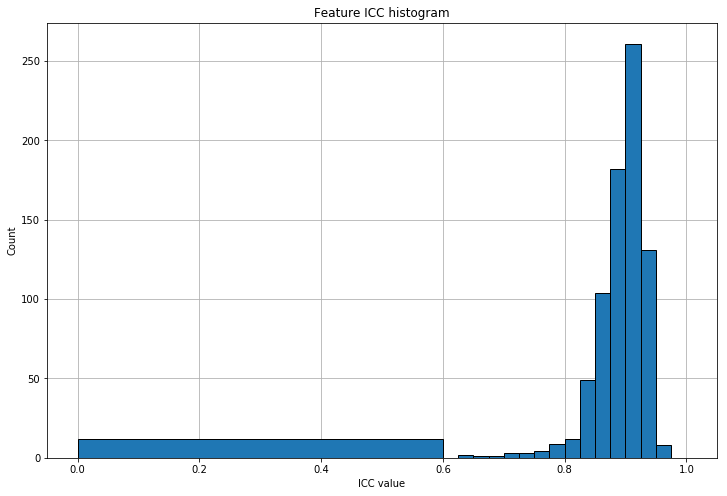

In [170]:
# Histogram
bins = np.linspace(0.6, 1, 17).tolist()
bins = [0] + bins
plt.figure(figsize=(12,8))
plt.grid(True, alpha=1)
plt.rc('axes', axisbelow=True)
plt.hist(iccs, bins=bins, edgecolor="black")
plt.title("Feature ICC histogram")
plt.xlabel("ICC value")
plt.ylabel("Count")
plt.savefig(RECORD_LABEL + "_icc_histo" + '.pdf')

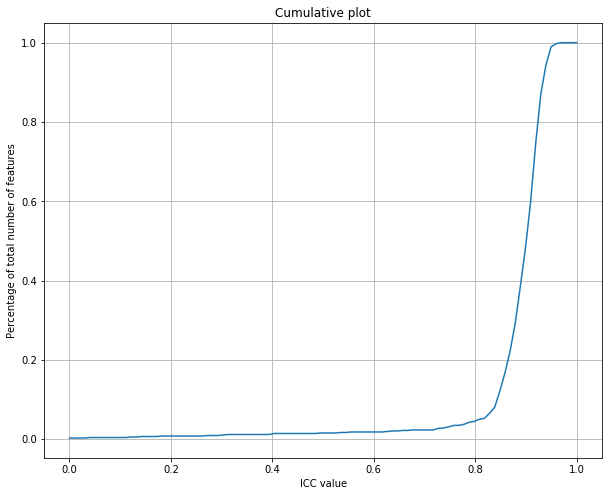

In [183]:
# Cumulative
y_values = np.linspace(0, 1, 100).tolist()
# y_values = list(reversed(y_values))
x_values = []
plt.figure(figsize=(10,8))
for y in y_values:
    n_features = len(iccs)
    x_values.append(np.mean(iccs <= y))
plt.grid(True)
plt.ylabel("Percentage of total number of features")
plt.xlabel("ICC value")
plt.title("Cumulative plot")
plt.plot(y_values, x_values)
plt.savefig(RECORD_LABEL + "_icc_cumu" + '.pdf')